In [59]:
import time
import tracemalloc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import hyperfpga_cluster as hfc
import ipyparallel as ipp
import json

with open("sparse_matrix_formats_100x100.json", "r") as f:
    data = json.load(f)
with open("sparse_matrix_formats_1000x1000_structured.json", "r") as f:
    datak = json.load(f)

nodes = hfc.get_nodes()
test_node = nodes[0]

cluster = hfc.HyperFPGACluster(nodes=test_node, firmware='basic_test', n_engines=1, engines_per_node=1)
cluster.create_profile()
await cluster.configure()

Assigned Nodes: ['hyperfpga-3be11-2-1']
Profile exists, rewritting configuration.
Uploading firmware...
b'/home/jupyter-kaust_ghala/Getting_Started/bitstreams/basic_test-3be11.dtbo' -> b'' 000.00.77
 Programming fpgas...
Time taken to load BIN is 186.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully

 Node Status
 host: hyperfpga-3be11-2-1 state: operating
 firmware: basic_test comblock: ['fifo_i', 'fifo_o', 'ram', 'regs_i', 'regs_o']



In [60]:
remote_client = cluster.start_and_connect_sync()
dview = remote_client[:]


Starting 1 engines with <class 'ipyparallel.cluster.launcher.SSHEngineSetLauncher'>
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1752671271-resl-client.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1752671271-resl-client.json
ensuring remote mlabadm@192.168.0.11:.ipython/profile_ssh/security/ exists
sending /home/jupyter-kaust_ghala/.ipython/profile_ssh/security/ipcontroller-1752671271-resl-engine.json to mlabadm@192.168.0.11:.ipython/profile_ssh/security/ipcontroller-1752671271-resl-engine.json
Running `python3 -m ipyparallel.engine --profile-dir=/home/mlabadm/.ipython/profile_ssh`
100%|██████████| 1/1 [00:10<00:00, 10.01s/engine]


### Input vector

In [37]:
x2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x3 = data["x_input_vector"]
x4 = datak["x_input_vector"]

## 1) Compressed Sparse Row (CSR)

In [38]:
@dview.remote(block=True)
def spmv_csr(row_ptr, col_index, values, x):
    num_rows = len(row_ptr) - 1
    y = [0.0] * num_rows
    for i in range(num_rows):
        sum_val = 0
        for k in range(row_ptr[i], row_ptr[i + 1]):
            sum_val += values[k] * x[col_index[k]]
        y[i] = sum_val
    return y

# 10x10
csr_row_ptr2 = [0, 4, 6, 7, 10, 11, 16, 19, 24, 27, 30]
csr_col_index2 = [1, 2, 7, 9, 1, 2, 5, 3, 4, 5, 3, 0, 1, 2, 3, 5, 2, 7, 9, 0, 3, 4, 5, 6, 0, 6, 8, 1, 2, 4]
csr_values2 = [5, 1, 3, 1, 5, 3, 2, 5, 5, 2, 4, 5, 2, 4, 4, 4, 3, 2, 5, 2, 2, 1, 1, 2, 3, 1, 4, 1, 2, 2]

# 100x100
csr_data = data["CSR_data"]
csr_indices = data["CSR_indices"]
csr_indptr = data["CSR_indptr"]

# 1000x1000
csr_data2 = datak["CSR_data"]
csr_indices2 = datak["CSR_indices"]
csr_indptr2 = datak["CSR_indptr"]

## 2) Compressed Sparse Column (CSC)

In [39]:
@dview.remote(block=True)
def spmv_csc(col_ptr, row_index, values, x):
    num_rows = max(row_index) + 1
    y = [0.0] * num_rows
    for j in range(len(col_ptr) - 1):
        for k in range(col_ptr[j], col_ptr[j + 1]):
            y[row_index[k]] += values[k] * x[j]
    return y

# 10x10
csc_col_ptr2 = [0, 3, 7, 12, 16, 19, 23, 25, 27, 28, 30]
csc_row_index2 = [5, 7, 8, 0, 1, 5, 9, 0, 1, 5, 6, 9, 3, 4, 5, 7, 3, 7, 9, 2, 3, 5, 7, 7, 8, 0, 6, 8, 0, 6]
csc_values2 = [5, 2, 3, 5, 5, 2, 1, 1, 3, 4, 3, 2, 5, 4, 4, 2, 5, 1, 2, 2, 2, 4, 1, 2, 1, 3, 2, 4, 1, 5]

# 100x100
csc_data = data["CSC_data"]
csc_indices = data["CSC_indices"]
csc_indptr = data["CSC_indptr"]

# 1000x1000
csc_data2 = datak["CSC_data"]
csc_indices2 = datak["CSC_indices"]
csc_indptr2 = datak["CSC_indptr"]

## 3) Coordinate (COO) Formate

In [40]:
@dview.remote(block=True)
def spmv_coo(row_index, col_index, values, x):
    num_rows = max(row_index) + 1
    y = [0.0] * num_rows
    for i in range(len(values)):
        y[row_index[i]] += values[i] * x[col_index[i]]
    return y

# 10x10
coo_row_index2 = [0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 4, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9]
coo_col_index2 = [1, 2, 7, 9, 1, 2, 5, 3, 4, 5, 3, 0, 1, 2, 3, 5, 2, 7, 9, 0, 3, 4, 5, 6, 0, 6, 8, 1, 2, 4]
coo_values2 = [5, 1, 3, 1, 5, 3, 2, 5, 5, 2, 4, 5, 2, 4, 4, 4, 3, 2, 5, 2, 2, 1, 1, 2, 3, 1, 4, 1, 2, 2]

# 100x100
coo_row = data["COO_row"]
coo_col = data["COO_col"]
coo_data = data["COO_data"]

# 1000x1000
coo_row2 = datak["COO_row"]
coo_col2 = datak["COO_col"]
coo_data2 = datak["COO_data"]

## 4) ELLPACK (ELL) Format

In [41]:
@dview.remote(block=True)
def spmv_ell(ell_values, ell_col_index, x):
    num_rows = len(ell_values)
    max_nnz = len(ell_values[0])
    y = [0.0] * num_rows
    for i in range(num_rows):
        for j in range(max_nnz):
            y[i] += ell_values[i][j] * x[ell_col_index[i][j]]
    return y

# 10x10
ell_values2 = [
    [5, 1, 3, 1, 0],
    [5, 3, 0, 0, 0],
    [2, 0, 0, 0, 0],
    [5, 5, 2, 0, 0],
    [4, 0, 0, 0, 0],
    [5, 2, 4, 4, 4],
    [3, 2, 5, 0, 0],
    [2, 2, 1, 1, 2],
    [3, 1, 4, 0, 0],
    [1, 2, 2, 0, 0]
]

ell_col_index2 = [
    [1, 2, 7, 9, -1],
    [1, 2, -1, -1, -1],
    [5, -1, -1, -1, -1],
    [3, 4, 5, -1, -1],
    [3, -1, -1, -1, -1],
    [0, 1, 2, 3, 5],
    [2, 7, 9, -1, -1],
    [0, 3, 4, 5, 6],
    [0, 6, 8, -1, -1],
    [1, 2, 4, -1, -1]
]

# 100x100
ell_values3 = data["ELL_values"]         
ell_col_index3 = data["ELL_col_index"]   

# 1000x1000
ell_values4 = datak["ELL_values"]         
ell_col_index4 = datak["ELL_col_index"]    


## 5) Sliced ELLPACK (SELL)

In [42]:
@dview.remote(block=True)
def spmv_sell(slice_height, slice_offsets, values, col_index, x):
    y = []
    offset = 0
    num_slices = len(slice_offsets)
    for slice_num in range(num_slices):
        rows_in_slice = min(slice_height, len(x) - slice_num * slice_height)
        cols_in_slice = (slice_offsets[slice_num] - offset) // rows_in_slice
        for i in range(rows_in_slice):
            sum_val = 0
            for j in range(cols_in_slice):
                idx = offset + j * rows_in_slice + i
                col = col_index[idx]
                val = values[idx]
                if col != -1:
                    sum_val += val * x[col]
            y.append(sum_val)
        offset = slice_offsets[slice_num]
    return y

# 10x10
slice_height = 2
sell_values2 = [5, 5, 1, 3, 3, 0, 1, 0, 2, 5, 0, 5, 0, 2, 4, 5, 0, 2, 0, 4, 0, 4, 0, 4, 3,
                2, 2, 2, 5, 1, 0, 1, 0, 2, 3, 1, 1, 2, 4, 2]
sell_col_index2 = [1, 1, 2, 2, 7, -1, 9, -1, 5, 3, -1, 4, -1, 5, 3, 0, -1, 1, -1, 2, -1, 3,
                   -1, 5, 2, 0, 7, 3, 9, 4, -1, 5, -1, 6, 0, 1, 6, 2, 8, 4]
slice_offsets2 = [8, 14, 24, 34, 40]

# 100x100
sell_values3 = data["SELL_values"]
sell_col_index3 = data["SELL_col_index"]
sell_slice_offsets3 = data["SELL_slice_offsets"]
sell_slice_height3 = data["SELL_slice_height"]

# 1000x1000
sell_values4 = datak["SELL_values"]
sell_col_index4 = datak["SELL_col_index"]
sell_slice_offsets4 = datak["SELL_slice_offsets"]
sell_slice_height4 = datak["SELL_slice_height"]


# Measure Performance

In [61]:
performance_data = []
def measure_performance(name, input_size):
    def decorator(func):
        def wrapper(*args, **kwargs):
            tracemalloc.start()
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            exec_time = end - start
            peak_kb = peak / 1024
            print(f"{name} | Input: {input_size} | Computation: {exec_time:.6f}s | Memory: {peak_kb:.2f} KB")
            performance_data.append({
                "Algorithm": name,
                "Input": input_size,
                "Computation Time (s)": exec_time,
                "Memory (KB)": peak_kb
            })
            return result
        return wrapper
    return decorator


## 10x10

In [62]:
@measure_performance("CSR", len(x2))
def run_csr2():
    return spmv_csr(csr_row_ptr2, csr_col_index2, csr_values2, x2)

# Transmission time
tx_start = time.perf_counter()
result = run_csr2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time

print(f"CSR | Transmission Time: {transmission_time:.6f}s")

@measure_performance("CSC", len(x2))
def run_csc2():
    return spmv_csc(csc_col_ptr2, csc_row_index2, csr_values2, x2)

# Transmission time
tx_start = time.perf_counter()
result = run_csc2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"CSC | Transmission Time: {transmission_time:.6f}s")

@measure_performance("COO", len(x2))
def run_coo2():
    return spmv_coo(coo_row_index2, coo_col_index2, coo_values2, x2)
    
# Transmission time
tx_start = time.perf_counter()
result = run_coo2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"COO | Transmission Time: {transmission_time:.6f}s")

@measure_performance("ELL", len(x2))
def run_ell2():
    return spmv_ell(ell_values2, ell_col_index2, x2)

# Transmission time
tx_start = time.perf_counter()
result = run_ell2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"ELL | Transmission Time: {transmission_time:.6f}s")

@measure_performance("SELL", len(x2))
def run_sell2():
    return spmv_sell(slice_height, slice_offsets2, sell_values2, sell_col_index2, x2)

# Transmission time
tx_start = time.perf_counter()
result = run_sell2()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"SELL | Transmission Time: {transmission_time:.6f}s")

CSR | Input: 10 | Computation: 0.016234s | Memory: 42.34 KB
CSR | Transmission Time: 0.000362s
CSC | Input: 10 | Computation: 0.017904s | Memory: 41.07 KB
CSC | Transmission Time: 0.000257s
COO | Input: 10 | Computation: 0.017328s | Memory: 40.70 KB
COO | Transmission Time: 0.000251s
ELL | Input: 10 | Computation: 0.016295s | Memory: 38.36 KB
ELL | Transmission Time: 0.000243s
SELL | Input: 10 | Computation: 0.016268s | Memory: 38.85 KB
SELL | Transmission Time: 0.000247s


## 100x100

In [63]:

@measure_performance("CSR", len(x3))
def run_csr3():
    return spmv_csr(csr_indptr, csr_indices, csr_data, x3)

# Transmission time
tx_start = time.perf_counter()
result = run_csr3()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"CSR | Transmission Time: {transmission_time:.6f}s")

@measure_performance("CSC", len(x3))
def run_csc3():
    return spmv_csc(csc_indptr, csc_indices, csr_data, x3)

# Transmission time
tx_start = time.perf_counter()
result = run_csc3()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"CSC | Transmission Time: {transmission_time:.6f}s")

@measure_performance("COO", len(x3))
def run_coo3():
    return spmv_coo(coo_row, coo_col, coo_data, x3)

# Transmission time
tx_start = time.perf_counter()
result = run_coo3()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"COO | Transmission Time: {transmission_time:.6f}s")

@measure_performance("ELL", len(x3))
def run_ell3():
    return spmv_ell(ell_values3, ell_col_index3, x3)

# Transmission time
tx_start = time.perf_counter()
result = run_ell3()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"ELL | Transmission Time: {transmission_time:.6f}s")

@measure_performance("SELL", len(x3))
def run_sell3():
    return spmv_sell(sell_slice_height3, sell_slice_offsets3, sell_values3, sell_col_index3, x3)

# Transmission time
tx_start = time.perf_counter()
result = run_sell3()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"SELL | Transmission Time: {transmission_time:.6f}s")

CSR | Input: 100 | Computation: 0.018968s | Memory: 52.13 KB
CSR | Transmission Time: 0.000328s
CSC | Input: 100 | Computation: 0.019476s | Memory: 54.04 KB
CSC | Transmission Time: 0.000275s
COO | Input: 100 | Computation: 0.020242s | Memory: 55.03 KB
COO | Transmission Time: 0.000265s
ELL | Input: 100 | Computation: 0.020348s | Memory: 64.58 KB
ELL | Transmission Time: 0.000313s
SELL | Input: 100 | Computation: 0.020218s | Memory: 57.15 KB
SELL | Transmission Time: 0.000259s


## 1000x1000

In [64]:
@measure_performance("CSR", len(x4))
def run_csr4():
    return spmv_csr(csr_indptr2, csr_indices2, csr_data2, x4)

# Transmission time
tx_start = time.perf_counter()
result = run_csr4()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"CSR | Transmission Time: {transmission_time:.6f}s")

@measure_performance("CSC", len(x4))
def run_csc4():
    return spmv_csc(csc_indptr2, csc_indices2, csr_data2, x4)

# Transmission time
tx_start = time.perf_counter()
result = run_csc4()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"CSC | Transmission Time: {transmission_time:.6f}s")

@measure_performance("COO", len(x4))
def run_coo4():
    return spmv_coo(coo_row2, coo_col2, coo_data2, x4)

# Transmission time
tx_start = time.perf_counter()
result = run_coo4()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"COO | Transmission Time: {transmission_time:.6f}s")

@measure_performance("ELL", len(x4))
def run_ell4():
    return spmv_ell(ell_values4, ell_col_index4, x4)

# Transmission time
tx_start = time.perf_counter()
result = run_ell4()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"ELL | Transmission Time: {transmission_time:.6f}s")

@measure_performance("SELL", len(x4))
def run_sell4():
    return spmv_sell(sell_slice_height4, sell_slice_offsets4, sell_values4, sell_col_index4, x4)

# Transmission time
tx_start = time.perf_counter()
result = run_sell4()
tx_end = time.perf_counter()
computation_time = performance_data[-1]["Computation Time (s)"]
transmission_time = (tx_end - tx_start) - computation_time
performance_data[-1]["Transmission Time (s)"] = transmission_time
print(f"SELL | Transmission Time: {transmission_time:.6f}s")


CSR | Input: 1000 | Computation: 0.034853s | Memory: 212.90 KB
CSR | Transmission Time: 0.000386s
CSC | Input: 1000 | Computation: 0.036769s | Memory: 212.20 KB
CSC | Transmission Time: 0.000327s
COO | Input: 1000 | Computation: 0.038068s | Memory: 235.74 KB
COO | Transmission Time: 0.000354s
ELL | Input: 1000 | Computation: 0.061538s | Memory: 378.84 KB
ELL | Transmission Time: 0.000383s
SELL | Input: 1000 | Computation: 0.047936s | Memory: 273.97 KB
SELL | Transmission Time: 0.000293s


# Plot

In [65]:
df = pd.DataFrame(performance_data)
print(df)


   Algorithm  Input  Computation Time (s)  Memory (KB)  Transmission Time (s)
0        CSR     10              0.016234    42.339844               0.000362
1        CSC     10              0.017904    41.067383               0.000257
2        COO     10              0.017328    40.703125               0.000251
3        ELL     10              0.016295    38.355469               0.000243
4       SELL     10              0.016268    38.850586               0.000247
5        CSR    100              0.018968    52.132812               0.000328
6        CSC    100              0.019476    54.041992               0.000275
7        COO    100              0.020242    55.026367               0.000265
8        ELL    100              0.020348    64.583984               0.000313
9       SELL    100              0.020218    57.153320               0.000259
10       CSR   1000              0.034853   212.904297               0.000386
11       CSC   1000              0.036769   212.201172          

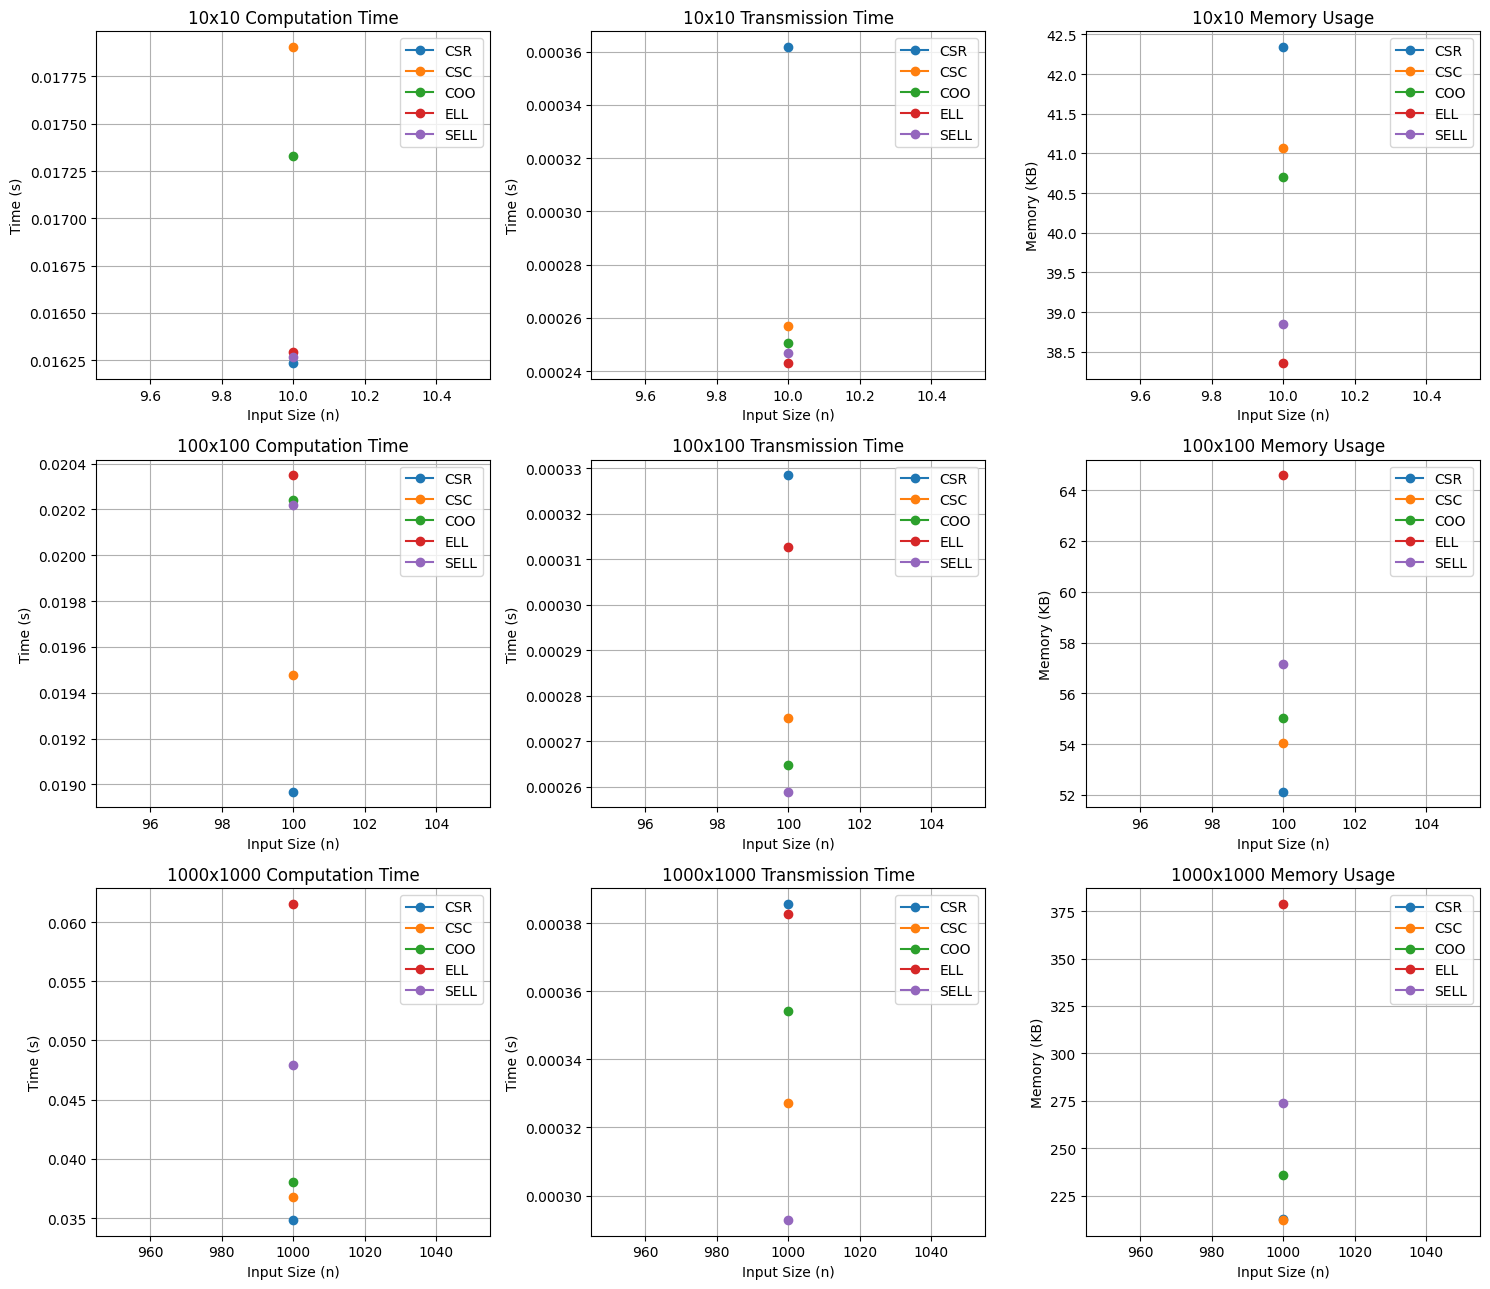

In [66]:
df_10x10 = df[df["Input"] == 10]
df_100x100 = df[df["Input"] == 100]
df_1000x1000 = df[df["Input"] == 1000]

plt.figure(figsize=(15, 13))

plt.subplot(3, 3, 1)
for alg in df_10x10["Algorithm"].unique():
    alg_df = df_10x10[df_10x10["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("10x10 Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2)
for alg in df_10x10["Algorithm"].unique():
    alg_df = df_10x10[df_10x10["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("10x10 Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 3)
for alg in df_10x10["Algorithm"].unique():
    alg_df = df_10x10[df_10x10["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("10x10 Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)

# -----------------------------------------

plt.subplot(3, 3, 4)
for alg in df_100x100["Algorithm"].unique():
    alg_df = df_100x100[df_100x100["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("100x100 Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 5)
for alg in df_100x100["Algorithm"].unique():
    alg_df = df_100x100[df_100x100["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("100x100 Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 6)
for alg in df_100x100["Algorithm"].unique():
    alg_df = df_100x100[df_100x100["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("100x100 Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)

# -----------------------------------------


plt.subplot(3, 3, 7)
for alg in df_1000x1000["Algorithm"].unique():
    alg_df = df_1000x1000[df_1000x1000["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)
plt.title("1000x1000 Computation Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 8)
for alg in df_1000x1000["Algorithm"].unique():
    alg_df = df_1000x1000[df_1000x1000["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)
plt.title("1000x1000 Transmission Time")
plt.xlabel("Input Size (n)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 9)
for alg in df_1000x1000["Algorithm"].unique():
    alg_df = df_1000x1000[df_1000x1000["Algorithm"] == alg]
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)
plt.title("1000x1000 Memory Usage")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.savefig("spmv_performance_plot.png", dpi=300)
plt.show()


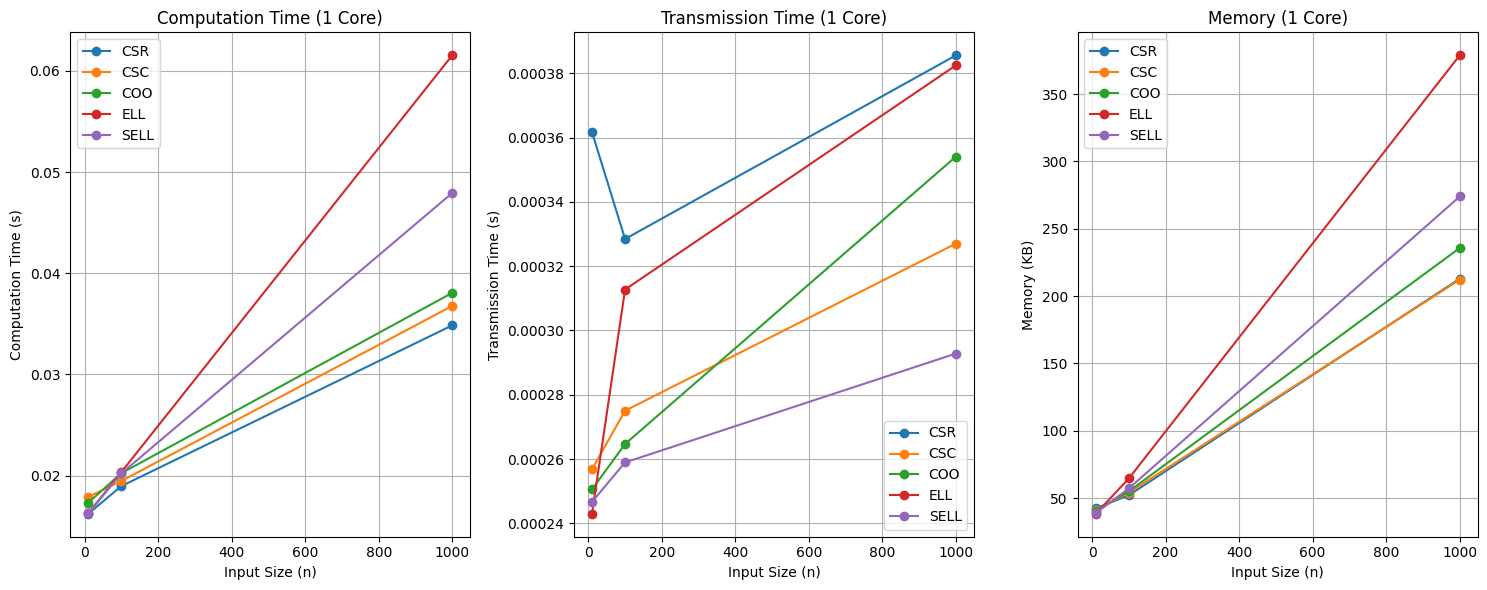

In [67]:
plt.figure(figsize=(15, 6))

plt.subplot(1,3,1)
for alg in df["Algorithm"].unique():
    alg_df = df[df["Algorithm"] == alg].sort_values(by="Input")
    plt.plot(alg_df["Input"], alg_df["Computation Time (s)"], marker='o', label=alg)

plt.title("Computation Time (1 Core)")
plt.xlabel("Input Size (n)")
plt.ylabel("Computation Time (s)")
plt.legend()
plt.grid(True)

#plt.savefig("spmv_time_vs_input_single_core.png", dpi=300)

plt.subplot(1,3,2)
for alg in df["Algorithm"].unique():
    alg_df = df[df["Algorithm"] == alg].sort_values(by="Input")
    plt.plot(alg_df["Input"], alg_df["Transmission Time (s)"], marker='o', label=alg)

plt.title("Transmission Time (1 Core)")
plt.xlabel("Input Size (n)")
plt.ylabel("Transmission Time (s)")
plt.legend()
plt.grid(True)

plt.subplot(1,3,3)
for alg in df["Algorithm"].unique():
    alg_df = df[df["Algorithm"] == alg].sort_values(by="Input")
    plt.plot(alg_df["Input"], alg_df["Memory (KB)"], marker='o', label=alg)

plt.title("Memory (1 Core)")
plt.xlabel("Input Size (n)")
plt.ylabel("Memory (KB)")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()
